# Basic text classification with 1D CNN

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_basic_text_classification.ipynb)

In this tutorial we learn how to perform text classification from raw text data and train a basic 1D Convolutional Neural Network to perform sentiment analysis using JAX. This tutorial is originally inspired by ["Text classification from scratch with Keras"](https://keras.io/examples/nlp/text_classification_from_scratch/#build-a-model).

We will use the IMDB movie review dataset to classify the review to "positive" and "negative" classes. We implement from scratch a simple model using Flax, train it and compute metrics on the test set.

## Setup

We will be using the following packages in this tutorial:
- [Tiktoken](https://github.com/openai/tiktoken) to tokenize the raw text
- [Grain](https://github.com/google/grain) for efficient data loading and batching
- [tqdm](https://tqdm.github.io/) for a progress bar to monitor the training progress.

In [1]:
!pip install grain tiktoken tqdm

### Load the data: IMDB movie review sentiment classification

Let us download the dataset and briefly inspect the structure. We will be using only two classes: "positive" and "negative" for the sentiment analysis.

In [2]:
!rm -rf /tmp/data/imdb
!mkdir -p /tmp/data/imdb
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz -O /tmp/data/imdb/aclImdb_v1.tar.gz
!cd /tmp/data/imdb/ && tar -xf aclImdb_v1.tar.gz

--2024-11-18 16:58:00--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘/tmp/data/imdb/aclImdb_v1.tar.gz’

/tmp/data/imdb/aclI 100%[===================>]  80.23M  17.8MB/s    in 8.8s    

2024-11-18 16:58:09 (9.13 MB/s) - ‘/tmp/data/imdb/aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [3]:
!echo "Number of positive samples in train set:"
!ls /tmp/data/imdb/aclImdb/train/pos | wc -l
!echo "Number of negative samples in train set:"
!ls /tmp/data/imdb/aclImdb/train/neg | wc -l
!echo "Number of positive samples in test set:"
!ls /tmp/data/imdb/aclImdb/test/pos | wc -l
!echo "Number of negative samples in test set:"
!ls /tmp/data/imdb/aclImdb/test/neg | wc -l
!echo "First 10 files with positive samples in train/test sets:"
!ls /tmp/data/imdb/aclImdb/train/pos | head
!ls /tmp/data/imdb/aclImdb/test/pos | head
!echo "Display a single positive sample:"
!cat /tmp/data/imdb/aclImdb/train/pos/6248_7.txt

Number of positive samples in train set:
12500
Number of negative samples in train set:
12500
Number of positive samples in test set:
12500
Number of negative samples in test set:
12500
First 10 files with positive samples in train/test sets:
0_9.txt
10000_8.txt
10001_10.txt
10002_7.txt
10003_8.txt
10004_8.txt
10005_7.txt
10006_7.txt
10007_7.txt
10008_7.txt
ls: write error: Broken pipe
0_10.txt
10000_7.txt
10001_9.txt
10002_8.txt
10003_8.txt
10004_9.txt
10005_8.txt
10006_7.txt
10007_10.txt
10008_8.txt
ls: write error: Broken pipe
Display a single positive sample:
Being an Austrian myself this has been a straight knock in my face. Fortunately I don't live nowhere near the place where this movie takes place but unfortunately it portrays everything that the rest of Austria hates about Viennese people (or people close to that region). And it is very easy to read that this is exactly the directors intention: to let your head sink into your hands and say "Oh my god, how can THAT be possible!

Next, we will:
- create the dataset Python class to read samples from the disk
- use [Tiktoken](https://github.com/openai/tiktoken) to encode raw text into tokens and
- use [Grain](https://github.com/google/grain) for efficient data loading and batching.

In [4]:
from pathlib import Path


class SentimentAnalysisDataset:
    def __init__(self, path: str | Path):
        self.path = Path(path)
        assert self.path.exists()

        pos_texts = list((self.path / "pos").glob("*.txt"))
        neg_texts = list((self.path / "neg").glob("*.txt"))
        self.text_files = pos_texts + neg_texts
        assert len(self.text_files) > 0
        # Label 0 for Positive comments
        # Label 1 for Negative comments
        self.labels = [0] * len(pos_texts) + [1] * len(neg_texts)

    def __len__(self) -> int:
        return len(self.text_files)

    def read_text_file(self, path: str | Path) -> str:
        with open(path, "r") as handler:
            lines = handler.readlines()
        return "\n".join(lines)

    def __getitem__(self, index: int) -> tuple[str, int]:
        label = self.labels[index]
        text = self.read_text_file(self.text_files[index])
        return {"text": text, "label": label}


root_path = Path("/tmp/data/imdb/aclImdb/")
train_dataset = SentimentAnalysisDataset(root_path / "train")
test_dataset = SentimentAnalysisDataset(root_path / "test")

print("- Number of samples in train and test sets:", len(train_dataset), len(test_dataset))
print("- First train sample:", train_dataset[0])
print("- First test sample:", test_dataset[0])

- Number of samples in train and test sets: 25000 25000
- First train sample: {'text': "Preston Waters, a 11 years old boy,has problems with his parents and brothers specially because of money issues. He is crazy to have his own house and his own rules,since his brothers always stole his saved money and his parents neglect his wishes. One awful day, Preston was riding his bicycle; It was the same day that the villain of the story,Quigley, was trying to scape from the Police and accidentally ran the car over Preston's bike. Needing to be far away from the police, Quigley gives in a hurry, a check to cover the damages of Preston's bike. The problem was: It was a blank check! Preston is a clever boy and decides to have a high price on that check: 1 million dollars! All that money gives Preston things that he always wished for, like a mansion with pool,lots of toys, and even a limousine! The problems start to begin when the FBI and Quigley wants to know where the money is, making Preston i

Now, we can create a string-to-tokens preprocessing transformation and set up data loaders. We are going to use the GPT-2 tokenizer via [Tiktoken](https://github.com/openai/tiktoken).

In [5]:
import numpy as np

import tiktoken
import grain.python as grain


seed = 12
train_batch_size = 128
test_batch_size = 2 * train_batch_size
tokenizer = tiktoken.get_encoding("gpt2")
# max length of tokenized text
max_length = 500
vocab_size = tokenizer.n_vocab


class TextPreprocessing(grain.MapTransform):
    def __init__(self, tokenizer, max_length: int = 256):
        self.tokenizer = tokenizer
        self.max_length = max_length

    def map(self, data):
        text = data["text"]
        encoded = self.tokenizer.encode(text)
        # Cut to max length
        encoded = encoded[:self.max_length]
        # Pad with zeros if needed
        encoded = np.array(encoded + [0] * (self.max_length - len(encoded)))
        return {
            "text": encoded,
            "label": data["label"],
        }


train_sampler = grain.IndexSampler(
    len(train_dataset),
    shuffle=True,
    seed=seed,
    shard_options=grain.NoSharding(),  # No sharding since this is a single-device setup
    num_epochs=1,                      # Iterate over the dataset for one epoch
)

test_sampler = grain.IndexSampler(
    len(test_dataset),
    shuffle=False,
    seed=seed,
    shard_options=grain.NoSharding(),  # No sharding since this is a single-device setup
    num_epochs=1,                      # Iterate over the dataset for one epoch
)


train_loader = grain.DataLoader(
    data_source=train_dataset,
    sampler=train_sampler,                 # Sampler to determine how to access the data
    worker_count=4,                        # Number of child processes launched to parallelize the transformations among
    worker_buffer_size=2,                  # Count of output batches to produce in advance per worker
    operations=[
        TextPreprocessing(tokenizer, max_length=max_length),
        grain.Batch(train_batch_size, drop_remainder=True),
    ]
)

test_loader = grain.DataLoader(
    data_source=test_dataset,
    sampler=test_sampler,                  # Sampler to determine how to access the data
    worker_count=4,                        # Number of child processes launched to parallelize the transformations among
    worker_buffer_size=2,                  # Count of output batches to produce in advance per worker
    operations=[
        TextPreprocessing(tokenizer, max_length=max_length),
        grain.Batch(test_batch_size),
    ]
)

In [6]:
train_batch = next(iter(train_loader))

In [7]:
print("Train encoded text batch info:", type(train_batch["text"]), train_batch["text"].shape, train_batch["text"].dtype)
print("Train labels batch info:", type(train_batch["label"]), train_batch["label"].shape, train_batch["label"].dtype)

Train encoded text batch info: <class 'grain._src.python.shared_memory_array.SharedMemoryArray'> (128, 500) int64
Train labels batch info: <class 'grain._src.python.shared_memory_array.SharedMemoryArray'> (128,) int64


Let's check few samples of the training batch. We expect to see integer tokens for the input text and integer value for the labels:

In [8]:
print("Train batch data:", train_batch["text"][:2, :12], train_batch["label"][:2])

Train batch data: [[  464  8258  2128   326   345   743  3285   618   345 16067   439   428]
 [ 5297    11   428  3180   257  9961 43469  2646   290   340   373   257]] [1 0]


## Model for text classification

We choose a simple 1D convnet to classify the text. The first layer of the model transforms input tokens into float features using an embedding layer (`nnx.Embed`), then they are encoded further with convolutions. Finally, we classify encoded features using fully-connected layers.

In [9]:
from typing import Callable

import jax
import jax.numpy as jnp
from flax import nnx


class TextConvNet(nnx.Module):
    def __init__(
        self,
        vocab_size: int,
        num_classes: int = 2,
        embed_dim: int = 256,
        hidden_dim: int = 320,
        dropout_rate: float = 0.5,
        conv_ksize: int = 12,
        activation_layer: Callable = nnx.relu,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        self.activation_layer = activation_layer
        self.token_embedding = nnx.Embed(
            num_embeddings=vocab_size,
            features=embed_dim,
            rngs=rngs,
        )
        self.dropout = nnx.Dropout(dropout_rate, rngs=rngs)
        self.conv1 = nnx.Conv(
            in_features=embed_dim,
            out_features=hidden_dim,
            kernel_size=conv_ksize,
            strides=conv_ksize // 2,
            rngs=rngs,
        )
        self.lnorm1 = nnx.LayerNorm(hidden_dim, rngs=rngs)
        self.conv2 = nnx.Conv(
            in_features=hidden_dim,
            out_features=hidden_dim,
            kernel_size=conv_ksize,
            strides=conv_ksize // 2,
            rngs=rngs,
        )
        self.lnorm2 = nnx.LayerNorm(hidden_dim, rngs=rngs)

        self.fc1 = nnx.Linear(hidden_dim, hidden_dim, rngs=rngs)
        self.fc2 = nnx.Linear(hidden_dim, num_classes, rngs=rngs)

    def __call__(self, x: jax.Array) -> jax.Array:
        # x.shape: (N, max_length)
        x = self.token_embedding(x)
        x = self.dropout(x)   # x.shape: (N, max_length, embed_dim)

        x = self.conv1(x)
        x = self.lnorm1(x)
        x = self.activation_layer(x)
        x = self.conv2(x)
        x = self.lnorm2(x)
        x = self.activation_layer(x)  # x.shape: (N, K, hidden_dim)

        x = nnx.max_pool(x, window_shape=(x.shape[1], ))  # x.shape: (N, 1, hidden_dim)
        x = x.reshape((-1, x.shape[-1]))  # x.shape: (N, hidden_dim)

        x = self.fc1(x)  # x.shape: (N, hidden_dim)
        x = self.activation_layer(x)
        x = self.dropout(x)
        x = self.fc2(x)  # x.shape: (N, 2)

        return x


# Let's check the model on a dummy input
x = jnp.ones((4, max_length), dtype="int32")
module = TextConvNet(vocab_size)
y = module(x)
print("Prediction shape (N, num_classes): ", y.shape)

Prediction shape (N, num_classes):  (4, 2)


In [30]:
model = TextConvNet(
    vocab_size,
    num_classes=2,
    embed_dim=128,
    hidden_dim=128,
    conv_ksize=7,
    activation_layer=nnx.relu,
)

## Train the model

We can now train the model using training data loader and compute metrics: accuracy and loss on test data loader.
Below we set up the optimizer and define the loss function as Cross-Entropy.
Next, we define the train step where we compute the loss value and update the model parameters.
In the eval step we use the model to compute the metrics: accuracy and loss value.

In [ ]:
import optax


num_epochs = 10
learning_rate = 0.0005
momentum = 0.9

optimizer = nnx.ModelAndOptimizer(model, optax.adam(learning_rate, momentum))

In [32]:
def compute_losses_and_logits(model: nnx.Module, batch_tokens: jax.Array, labels: jax.Array):
    logits = model(batch_tokens)

    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=labels
    ).mean()
    return loss, logits

In [33]:
@nnx.jit
def train_step(
    model: nnx.Module, optimizer: nnx.Optimizer, batch: dict[str, jax.Array]
):
    # Convert numpy arrays to jax.Array on GPU
    batch_tokens = jnp.array(batch["text"])
    labels = jnp.array(batch["label"], dtype=jnp.int32)

    grad_fn = nnx.value_and_grad(compute_losses_and_logits, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch_tokens, labels)

    optimizer.update(grads)  # In-place updates.

    return loss


@nnx.jit
def eval_step(
    model: nnx.Module, batch: dict[str, jax.Array], eval_metrics: nnx.MultiMetric
):
    # Convert numpy arrays to jax.Array on GPU
    batch_tokens = jnp.array(batch["text"])
    labels = jnp.array(batch["label"], dtype=jnp.int32)
    loss, logits = compute_losses_and_logits(model, batch_tokens, labels)

    eval_metrics.update(
        loss=loss,
        logits=logits,
        labels=labels,
    )

In [34]:
eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Accuracy(),
)


train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "test_loss": [],
    "test_accuracy": [],
}

In [35]:
import tqdm


bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"
train_total_steps = len(train_dataset) // train_batch_size


def train_one_epoch(epoch):
    model.train()  # Set model to the training mode: e.g. update batch statistics
    with tqdm.tqdm(
        desc=f"[train] epoch: {epoch}/{num_epochs}, ",
        total=train_total_steps,
        bar_format=bar_format,
        leave=True,
    ) as pbar:
        for batch in train_loader:
            loss = train_step(model, optimizer, batch)
            train_metrics_history["train_loss"].append(loss.item())
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)


def evaluate_model(epoch):
    # Compute the metrics on the train and val sets after each training epoch.
    model.eval()  # Set model to evaluation model: e.g. use stored batch statistics

    eval_metrics.reset()  # Reset the eval metrics
    for test_batch in test_loader:
        eval_step(model, test_batch, eval_metrics)

    for metric, value in eval_metrics.compute().items():
        eval_metrics_history[f'test_{metric}'].append(value)

    print(f"[test] epoch: {epoch + 1}/{num_epochs}")
    print(f"- total loss: {eval_metrics_history['test_loss'][-1]:0.4f}")
    print(f"- Accuracy: {eval_metrics_history['test_accuracy'][-1]:0.4f}")

Now, we can start the training.

In [36]:
%%time

for epoch in range(num_epochs):
    train_one_epoch(epoch)
    evaluate_model(epoch)

[train] epoch: 0/10, [192/195], loss=0.697 [00:05<00:00]


[test] epoch: 1/10
- total loss: 0.6923
- Accuracy: 0.5106


[train] epoch: 1/10, [192/195], loss=0.691 [00:03<00:00]


[test] epoch: 2/10
- total loss: 0.6922
- Accuracy: 0.5422


[train] epoch: 2/10, [192/195], loss=0.678 [00:03<00:00]


[test] epoch: 3/10
- total loss: 0.6754
- Accuracy: 0.6263


[train] epoch: 3/10, [192/195], loss=0.339 [00:03<00:00]


[test] epoch: 4/10
- total loss: 0.4050
- Accuracy: 0.8267


[train] epoch: 4/10, [192/195], loss=0.215 [00:03<00:00]


[test] epoch: 5/10
- total loss: 0.3307
- Accuracy: 0.8664


[train] epoch: 5/10, [192/195], loss=0.167 [00:03<00:00]


[test] epoch: 6/10
- total loss: 0.3100
- Accuracy: 0.8764


[train] epoch: 6/10, [192/195], loss=0.112 [00:03<00:00] 


[test] epoch: 7/10
- total loss: 0.3434
- Accuracy: 0.8692


[train] epoch: 7/10, [192/195], loss=0.0814 [00:03<00:00]


[test] epoch: 8/10
- total loss: 0.3653
- Accuracy: 0.8760


[train] epoch: 8/10, [192/195], loss=0.0982 [00:03<00:00]


[test] epoch: 9/10
- total loss: 0.4136
- Accuracy: 0.8664


[train] epoch: 9/10, [192/195], loss=0.0731 [00:03<00:00]


[test] epoch: 10/10
- total loss: 0.4443
- Accuracy: 0.8664
CPU times: user 25.8 s, sys: 3.42 s, total: 29.3 s
Wall time: 1min 17s


Let's visualize the collected metrics:

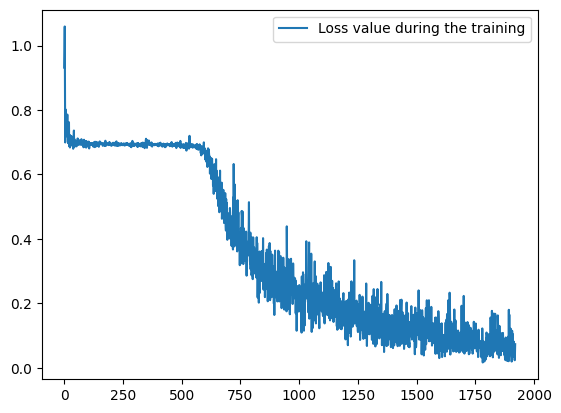

In [37]:
import matplotlib.pyplot as plt


plt.plot(train_metrics_history["train_loss"], label="Loss value during the training")
plt.legend()

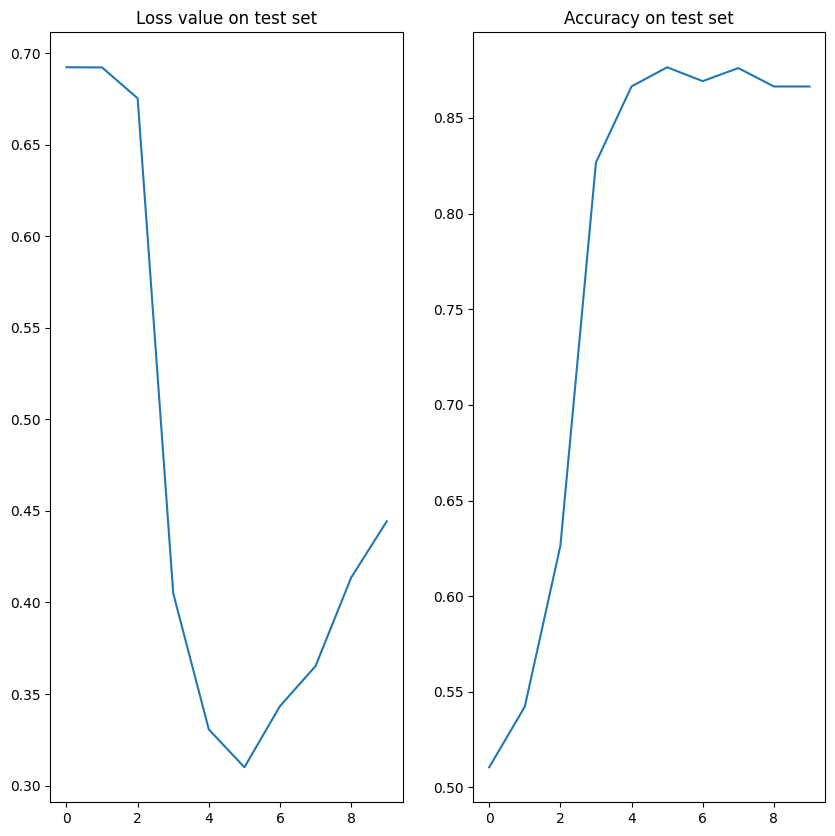

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].set_title("Loss value on test set")
axs[0].plot(eval_metrics_history["test_loss"])
axs[1].set_title("Accuracy on test set")
axs[1].plot(eval_metrics_history["test_accuracy"])

We can observe that the model starts overfitting after the 5-th epoch and the best accuracy it could achieve is around 0.87. Let us also check few model's predictions on the test data:

In [58]:
data = test_dataset[10]

In [60]:
text_processing = TextPreprocessing(tokenizer, max_length=max_length)
processed_data = text_processing.map(data)
model.eval()
preds = model(processed_data["text"][None, :])
pred_label = preds.argmax(axis=-1).item()
confidence = nnx.softmax(preds, axis=-1)

print("- Text:\n", data["text"])
print("")
print(f"- Expected review sentiment: {'positive' if data['label'] == 0 else 'negative'}")
print(f"- Predicted review sentiment: {'positive' if pred_label == 0 else 'negative'}, confidence: {confidence[0, pred_label]:.3f}")

- Text:
 Let me say first off that I am a huge fan of the original series Lonesome Dove and the book it was based from. I have put off watching this sequel for the better part of 10 years due to the bad reviews I'd heard about it. If Tommy Lee Jones wasn't playing Capt. Call I didn't see the point. If Larry McMurtry wasn't involved why should I care? How wrong I was.<br /><br />This is in so many ways a worthy sequel to Lonesome Dove, maybe even more so than the dark mood of Streets Of Laredo. The story, acting, production, cinematography are all top-notch. Of course the script isn't as colorful as Lonesome Dove but it has it's moments. And, much to my surprise, there are bits of Lonesome Done in this series; the relationship between July and Clara, completely dismissed in the prequel, is brought up here almost identical to the book, a most welcome surprise. The story isn't all roses, it has it's surprises too. By far the biggest surprise is Jon Voight's interpretation of Capt. Call. W

In [65]:
data = test_dataset[20]

In [66]:
text_processing = TextPreprocessing(tokenizer, max_length=max_length)
processed_data = text_processing.map(data)
model.eval()
preds = model(processed_data["text"][None, :])
pred_label = preds.argmax(axis=-1).item()
confidence = nnx.softmax(preds, axis=-1)

print("- Text:\n", data["text"])
print("")
print(f"- Expected review sentiment: {'positive' if data['label'] == 0 else 'negative'}")
print(f"- Predicted review sentiment: {'positive' if pred_label == 0 else 'negative'}, confidence: {confidence[0, pred_label]:.3f}")

- Text:
 One of the best TV shows out there, if not the best one. Why? Simple: it has guts to show us real life in prison, without any clichés and predictable twists. This is not Prison Break or any other show, actually comparing to Oz the show Sopranos look like story for children's. Profanity, cursing, shots of explicit violence and using drugs, disgusting scenes of male sexual organs and rapes... all this and more in Oz. But this is not the best part of Oz; the characters are the strongest point of this show; they're all excellent and not annoying, despite the fact we are looking at brutal criminals. The actors are excellent, my favorite are the actors who are playing Ryan O'Reilly and Tobias Beecher, because they're so unique and changing their behavior completely. And most of all... the don't have no remorse for their actions. Overall... Oz is amazing show, the best one out there. Forget about CSI and shows about stupid doctors... this is the deal... OZ!

- Expected review sentime

## Further reading

In this tutorial we implemented from scratch a simple convolutional neural network and trained it on a text classification dataset. Trained model shows 87% classification accuracy due to its convolutional nature. Next steps to improve the metrics could be to change the model to a transformer-based architecture.

- Model checkpointing and exporting using [Orbax](https://orbax.readthedocs.io/en/latest/).
- Other NLP tutorials in [jax-ai-stack](https://jax-ai-stack.readthedocs.io/en/latest/getting_started.html).